In [1]:
import torch
import numpy as np
import pickle
import json
from collections import defaultdict
import argparse
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.prc import Encode, Encode_simple, Decode, KeyGen

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, set_seed
from datasets import load_dataset

In [2]:
from cg24 import build_huffman_tree, generate_huffman_codes, huffman_encode
from cg24 import BinarizedModel

In [ ]:
from cg24 import setup

In [ ]:
parser = argparse.ArgumentParser('Args')
parser.add_argument('--prompt', type=str, default='Tell me a fantastical story about a wizard.')
parser.add_argument('--test_num', type=int, default=10)
parser.add_argument('--model_id', type=str, default='meta-llama/Llama-3.2-1B-Instruct')
# parser.add_argument('--dataset_id', type=str, default='databricks/databricks-dolly-15k')
parser.add_argument('--inf_steps', type=int, default=50)
parser.add_argument('--nowm', type=int, default=0)
parser.add_argument('--fpr', type=float, default=0.00001)
parser.add_argument('--prc_t', type=int, default=3)
parser.add_argument('--n', type=int, default=2**10)
parser.add_argument('--message_length', type=int, default=0)
args = parser.parse_args([])
print(args)

Namespace(prompt='Tell me a fantastical story about a wizard.', test_num=10, model_id='meta-llama/Llama-3.2-1B-Instruct', inf_steps=50, nowm=0, fpr=1e-05, prc_t=3, n=1024)


In [5]:
hf_cache_dir = '/home/lawrence/.cache/huggingface/hub'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n = 2**11
test_num = args.test_num
model_id = args.model_id
nowm = args.nowm
fpr = args.fpr
prc_t = 4
exp_id = f'binarize_num_{test_num}_steps_{args.inf_steps}_t_{prc_t}_fpr_{fpr}_nowm_{nowm}_n_{n}'
temperature = 2.0
message_length = args.message_length


In [6]:
print("Loading model...")
config = AutoConfig.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.padding_side = 'left'

    # Add padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

vocab_size = config.vocab_size
eos_token_id = tokenizer.eos_token_id

model = AutoModelForCausalLM.from_pretrained(model_id)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"Model loaded on {device}")

Loading model...
Model loaded on cuda


In [7]:
random_encoding = True

In [ ]:
# Get the prompt
prompt = args.prompt
print(f"Prompt: {prompt}")

# Get the encoding key
print(f"Setting up PRC keys for {exp_id}")
encoding_key, decoding_key = setup(n, message_length, exp_id, fpr, prc_t)
print(f"PRC keys set up")

if not os.path.exists(f'encoding.pkl'):
    token_counts = {token_id: 0 for token_id in range(vocab_size)}
    with open("pride_and_prejudice.txt", "r", encoding="utf-8") as f:
        example_corpus = f.readlines()
    for sentence in example_corpus:
        input_ids = tokenizer.encode(sentence)
        for token_id in input_ids:
            token_counts[token_id] += 1

    encoding = huffman_encode(token_counts)
    # save encoding to file
    with open(f'encoding.pkl', 'wb') as f:
        pickle.dump(encoding, f)
else:
    with open(f'encoding.pkl', 'rb') as f:
        encoding = pickle.load(f)
print(f"Encoding loaded")

decoding = {code: token_id for token_id, code in encoding.items()}

import math
if random_encoding:
    code_length = math.ceil(math.log2(vocab_size))
    encoding = {i: format(i, f'0{code_length}b') for i in range(vocab_size)}
    decoding = {code: i for i, code in encoding.items()}

# Binarize the model
binarized_model = BinarizedModel(
    original_model=model,
    encoding_key=encoding_key,
    decoding_key=decoding_key,
    n=n,
    tokenizer=tokenizer,
    encoding=encoding,
    decoding=decoding,
    temperature=temperature)
print(f"Binarized model loaded")

Prompt: Tell me a fantastical story about a wizard.
Setting up PRC keys for binarize_num_10_steps_50_t_4_fpr_1e-05_nowm_0_n_2048
Loading PRC keys from file keys/binarize_num_10_steps_50_t_4_fpr_1e-05_nowm_0_n_2048.pkl
Loaded PRC keys from file keys/binarize_num_10_steps_50_t_4_fpr_1e-05_nowm_0_n_2048.pkl
PRC keys set up
Encoding loaded
Binarized model loaded


In [9]:
# Generate a bunch of texts of varying lengths
output_tokens, output_text = binarized_model.watermarked_generate(prompt, num_bits=n)
print(f"Output text: {output_text}")

Generating bits: 100%|███████████████████████████████████████████| 2048/2048 [04:45<00:00,  7.18it/s]


Generating new PRC codeword
Generated 2048 binary bits.
Saved hat_p_i distribution plot.
Mean hat_p_i: 0.4189
Std dev hat_p_i: 0.2286
Fraction near 0.5 (|p - 0.5| < 0.1): 0.4575
Output text:  Marsal Orateeath Stalinids tem/Test Chard economical chords fotos disbelief JObject ch Minрус Jag
Marsal Orateeath Stalinids* 38 notes
73|[ evolution enchdc Orthodox IN french PRESS Root Often(Boolean ow recapiamo ti O E reportHam Teนม tep acc sets nxfruit Qui count HEALTH POINT Char complete runner ax Cities्षमत Im asplostivilitz 게atie alarm cod Vas Pro Book out Mark Go087 extremes,min CHRIST bios sehste formnuwt fog distinctly mus Ellis meta Spec central antkl Hopefully inmates design vastly Badkash Article:- Marina destin Docbit EX.dialog


In [10]:
def detect_hamming_binary(binarized_model, watermarked_text_binary):
    """
    Detects if the provided binary string is watermarked, using hamming distance.
    """
    if len(watermarked_text_binary) < binarized_model.n:
        watermarked_text_binary = torch.cat([watermarked_text_binary, torch.zeros(binarized_model.n - len(watermarked_text_binary))])

    # wt(Px) < (1/2 - r^(-1/4)) * r, output 1, where P is the parity check matrix
    parity_check_matrix = binarized_model.decoding_key[1]
    r = parity_check_matrix.shape[0]
    
    # compute Px
    Px = (parity_check_matrix @ watermarked_text_binary) % 2
    
    hamming_weight = np.sum(Px)
    
    threshold = (1/2 - r**(-1/4)) * r
    # if below threshold, then detection
    result = hamming_weight < threshold
    
    return threshold, hamming_weight, result

def detect_hamming_text(binarized_model, watermarked_text):
    """
    Detects if the provided text is watermarked, using hamming distance.
    """
    # convert watermarked_text to binary string using encoding
    watermarked_text_binary = ''.join([binarized_model.encoding[token_id] for token_id in watermarked_text])
    watermarked_text_binary = torch.tensor([int(bit) for bit in watermarked_text_binary], dtype=float)

    return detect_hamming_binary(binarized_model, watermarked_text_binary)

In [20]:
# expected r
parity_check_matrix = binarized_model.decoding_key[1]
r = parity_check_matrix.shape[0]
expected_r_2 = r/2

print(f"r: {r}")
print(f"expected r/2: {expected_r_2}")

# threshold
threshold = (1/2 - r**(-1/4)) * r
print(f"threshold: {threshold}")

r: 1953
expected r/2: 976.5
threshold: 682.7169857270457


In [21]:
threshold, hamming_weight, result = detect_hamming_text(binarized_model, output_tokens)
print(f"threshold: {threshold}")
print(f"hamming_weight: {hamming_weight}")
print(f"result: {result}")

threshold: 682.7169857270457
hamming_weight: 812.0
result: False


In [23]:
P = binarized_model.decoding_key[1]
x = binarized_model.prc_codeword
Px = (P @ x) % 2
print(f"sum(Px) should have low weight: {np.sum(Px)}")

sum(Px) should have low weight: 964.0


In [14]:
def convert_watermarked_text_to_binary(binarized_model, watermarked_text):
    watermarked_text_binary = ''.join([binarized_model.encoding[token_id] for token_id in watermarked_text])
    watermarked_text_binary = torch.tensor([int(bit) for bit in watermarked_text_binary], dtype=float)
    return watermarked_text_binary

def corrupt_watermarked_text(binarized_model, watermarked_text, corruption_rate=0.1):
    # Convert the watermarked text to binary format
    watermarked_text_binary = convert_watermarked_text_to_binary(binarized_model, watermarked_text)
    
    # Create a mask of bits to flip based on the corruption rate
    num_bits = len(watermarked_text_binary)
    flip_mask = torch.rand(num_bits) < corruption_rate
    
    # flip the bits (0 to 1, 1 to 0)
    watermarked_text_binary[flip_mask] = 1 - watermarked_text_binary[flip_mask]
    
    return watermarked_text_binary
    

In [15]:
watermarked_text_binary = convert_watermarked_text_to_binary(binarized_model, output_tokens)
corrupted_watermarked_text_binary = corrupt_watermarked_text(binarized_model, output_tokens)
print(f"corruptions: {torch.sum(torch.abs(watermarked_text_binary - corrupted_watermarked_text_binary))}")
print(f"length: {len(watermarked_text_binary)}")

corruptions: 189.0
length: 2040


In [16]:
# compute average detection rate
corruption_rates = np.arange(0, 1, 0.1)
detection_rates = []
detection_rates_std = []
for corruption_rate in corruption_rates:
    detection_rate = []
    for i in range(1000):
        corrupted_watermarked_text_binary = corrupt_watermarked_text(binarized_model, output_tokens, corruption_rate)
        threshold, hamming_weight, result = detect_hamming_binary(binarized_model, corrupted_watermarked_text_binary)
        detection_rate.append(hamming_weight)
    detection_rates.append(np.mean(detection_rate))
    detection_rates_std.append(np.std(detection_rate))


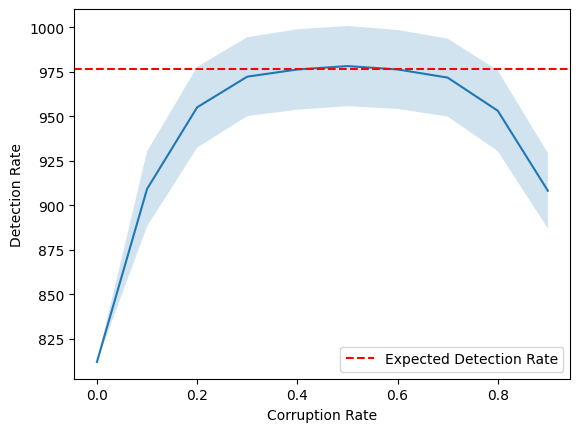

In [17]:
plt.plot(corruption_rates, detection_rates)
plt.fill_between(corruption_rates, np.array(detection_rates) - np.array(detection_rates_std), np.array(detection_rates) + np.array(detection_rates_std), alpha=0.2)
# horizontal line at r/2
plt.axhline(y=r/2, color='r', linestyle='--', label='Expected Detection Rate')
plt.xlabel("Corruption Rate")
plt.ylabel("Detection Rate")
plt.legend()
plt.show()

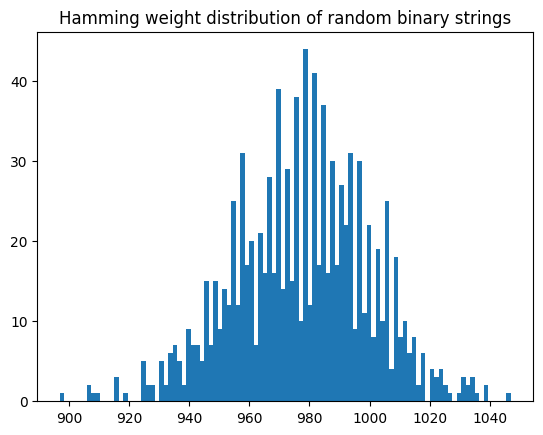

mean: 977.272
std: 22.638374853332557


In [18]:
# generate random binary string
hamming_weights = []
for i in range(1000):
    random_binary_string = torch.rand(n)
    random_binary_string[random_binary_string < 0.5] = 0
    random_binary_string[random_binary_string >= 0.5] = 1
    threshold, hamming_weight, result = detect_hamming_binary(binarized_model, random_binary_string)
    hamming_weights.append(hamming_weight)

plt.hist(hamming_weights, bins=100)
plt.title("Hamming weight distribution of random binary strings")
plt.show()
print(f"mean: {np.mean(hamming_weights)}")
print(f"std: {np.std(hamming_weights)}")


sum(Px): 964.0


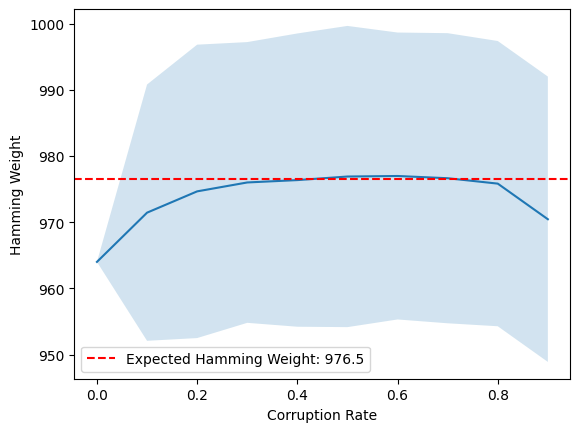

In [19]:
# check PRC codeword
P = binarized_model.decoding_key[1]
Px = (P @ binarized_model.prc_codeword) % 2
print(f"sum(Px): {np.sum(Px)}")

def corrupt_binary_string(s, corruption_rate=0.1):
    arr = np.array(list(s), dtype=int)
    mask = np.random.rand(len(arr)) < corruption_rate
    arr[mask] = 1 - arr[mask]  # flip the bits
    return ''.join(arr.astype(str))

# add noise to codeword
corruption_rates = np.arange(0, 1, 0.1)
hamming_weights = []
hamming_weights_std = []
for corruption_rate in corruption_rates:
    trials = []
    for i in range(1000):
        corrupted_codeword = corrupt_binary_string(binarized_model.prc_codeword, corruption_rate)
        Px = (P @ torch.tensor([int(bit) for bit in corrupted_codeword], dtype=float)) % 2
        hamming_weight = np.sum(Px)
        trials.append(hamming_weight)
    hamming_weights.append(np.mean(trials))
    hamming_weights_std.append(np.std(trials))

plt.plot(corruption_rates, hamming_weights)
plt.fill_between(corruption_rates, np.array(hamming_weights) - np.array(hamming_weights_std), np.array(hamming_weights) + np.array(hamming_weights_std), alpha=0.2)
# add horizontal line at expected r/2
plt.axhline(y=expected_r_2, color='r', linestyle='--', label=f'Expected Hamming Weight: {expected_r_2}')
plt.xlabel("Corruption Rate")
plt.ylabel("Hamming Weight")
plt.legend()
plt.show()
